In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from g2p_en import G2p
import re
import torch.nn.utils as utils

import math

import pickle
import Levenshtein
import os

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

In [2]:
import sys, os
sys.path.insert(0, "/home/k2/src/textlesslib")  
import textless
print("textless loaded from:", textless.__file__)

import os, re, pathlib, torch, torchaudio
from textless.vocoders.tacotron2.vocoder import TacotronVocoder

textless loaded from: /home/k2/src/textlesslib/textless/__init__.py


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vocoder = TacotronVocoder.by_name("hubert-base-ls960", "kmeans", 100).to(device)
srOut = vocoder.output_sample_rate
print("vocoder SR:", srOut, "| device:", device)

/home/k2/src/textlesslib/textless/vocoders/tacotron2/vocoder.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(tacotron_model_path, map_location=t

vocoder SR: 22050 | device: cuda


In [ ]:
"""
Train GENERAL-VOCAB EMG-to-audio conversion.

For description of the data, please see largeVocabDataVisualization.ipynb

Given a sentence transcription:
    1) Obtain audio via gTTS.
    2) From audio, obtain HuBERT units.
    3) Decode HuBERT units using CTC loss. 
"""

"""https://pypi.org/project/Levenshtein/ - install this Lev distance."""

In [4]:
DATA = pickle.load(open("/mnt/dataDrive/emg2Audio/cleanData/DATA.pkl", "rb"))
unitLABELS = np.load("/mnt/dataDrive/emg2Audio/cleanData/HuBERTLABELS.pkl", allow_pickle = True)
textLABELS = pickle.load(open("/mnt/dataDrive/emg2Audio/cleanData/textLABELS.pkl", "rb"))

In [5]:
"""
English phoneme definitions.
"""

tok2id = {}
with open("/mnt/dataDrive/emgFullCorpora/toUpload/DATA/ckptsLargeVocab/lang_phone/tokens.txt") as f:
    for line in f:
        s, i = line.strip().split()
        i = int(i)
        if s == "<eps>" or s.startswith("#"):
            continue
        tok2id[s] = i
PHONE_DEF = tok2id


def phoneToId(p):
    return PHONE_DEF[p]

g2p = G2p()

In [6]:
MAX = max(len(u) for u in unitLABELS)
print(MAX)
unitizedLabels = np.zeros((len(unitLABELS), MAX), dtype = np.int64)
for i, seq in enumerate(unitLABELS):
    unitizedLabels[i, :len(seq)] = np.asarray(seq, dtype = np.int64)
unitLabelLengths = np.array([len(seq) for seq in unitLABELS], dtype = np.int32)

189


In [7]:
"""
Phonemize the sentences.
"""

phonemizedSentences = []

for i in range(len(textLABELS)):
    phones = []
    for p in g2p(textLABELS[i]): 
        p = re.sub(r'[0-9]', '', p)   
        if re.match(r'[A-Z]+', p): 
            phones.append(p)
    phonemizedSentences.append(phones)

"""
Convert phone-to-indices using look-up dictionary PHONE_DEF.
"""

phoneIndexedSentences = []
for i in range(len(phonemizedSentences)):
    current = phonemizedSentences[i]
    phoneID = []
    for j in range(len(current)):
        phoneID.append(phoneToId(current[j]))
    phoneIndexedSentences.append(phoneID)

def tokenIdToClassIdx(tokenId: int) -> int:
    return tokenId - 1   

def phoneSeqToClassIdxSeq(phoneSeq):
    return [tokenIdToClassIdx(PHONE_DEF[p]) for p in phoneSeq]

classIndexedSentences = [phoneSeqToClassIdxSeq(seq) for seq in phonemizedSentences]

"""
Pad the phone transcribed sentences to a common length (to be used with CTC loss).
"""

phonemizedLabels = np.zeros((len(classIndexedSentences), 76)) - 1
for i in range(len(classIndexedSentences)):
    phonemizedLabels[i, 0:len(classIndexedSentences[i])] = classIndexedSentences[i]

labelLengths = np.zeros((len(classIndexedSentences)))
for i in range(len(classIndexedSentences)):
    labelLengths[i] = len(classIndexedSentences[i])

In [8]:
"""
z-normalize the data along the time dimension.
"""

normDATA = []
for i in range(len(DATA)):
    Mean = np.mean(DATA[i], axis = -1)
    Std = np.std(DATA[i], axis = -1)
    normDATA.append((DATA[i] - Mean[..., np.newaxis])/Std[..., np.newaxis])

In [9]:
from emgJitter import (
    computeConvSeq,
    EpochJitterEMGDataset,)
from torch.nn.utils.rnn import pad_sequence

In [10]:
@torch.no_grad()
def padCollateSpd(batch, C: int, padValue: int = -1):
    """
    batch: list of tuples:
      (covSeq, phoneSeq, phoneLen, unitSeq, unitLen)
    Returns:
      inputs: (N, T_max, C, C)
      phoneTargets: (N, LpMax) [padded with padValue]
      unitTargets : (N, LuMax) [padded with padValue]
      inputLengths : (N,)
      phoneTargetLengths: (N,)
      unitTargetLengths : (N,)
    """
    covSeqs, phoneSeqs, phoneLens, unitSeqs, unitLens = zip(*batch)
    B = len(batch)

    Tmax = max(int(x.shape[0]) for x in covSeqs)
    inputs = covSeqs[0].new_zeros((B, Tmax, C, C))
    I = torch.eye(C, dtype = inputs.dtype)
    for b, x in enumerate(covSeqs):
        Tb = int(x.shape[0])
        inputs[b, :Tb] = x
        if Tb < Tmax:
            inputs[b, Tb:Tmax] = I

    LpMax = max(int(L) for L in phoneLens)
    LuMax = max(int(L) for L in unitLens)

    phoneTargets = torch.full((B, LpMax), padValue, dtype = torch.long)
    unitTargets  = torch.full((B, LuMax), padValue, dtype = torch.long)

    for b, (p, Lp) in enumerate(zip(phoneSeqs, phoneLens)):
        p = torch.as_tensor(p).view(-1)
        phoneTargets[b, :int(Lp)] = p[:int(Lp)]

    for b, (u, Lu) in enumerate(zip(unitSeqs, unitLens)):
        u = torch.as_tensor(u).view(-1)
        unitTargets[b, :int(Lu)] = u[:int(Lu)]

    inputLengths        = torch.as_tensor([int(t.shape[0]) for t in covSeqs], dtype = torch.int32)
    phoneTargetLengths  = torch.as_tensor(phoneLens, dtype = torch.int32)
    unitTargetLengths   = torch.as_tensor(unitLens,  dtype = torch.int32)

    return (inputs, phoneTargets, unitTargets,
            inputLengths, phoneTargetLengths, unitTargetLengths)

In [11]:
C = 31
fs = 5000
winMs, hopMs = 25.0, 20.0     
shrinkAlpha = 0.1
DIAG = False
diagOnly = False

emgTrain, emgVal, emgTest = normDATA[:8500], normDATA[8500:9260], normDATA[9260:]

phTrain, phVal, phTest = phonemizedLabels[:8500], phonemizedLabels[8500:9260], phonemizedLabels[9260:]
phLTrain, phLVal, phLTest = labelLengths[:8500], labelLengths[8500:9260], labelLengths[9260:]

huTrain, huVal, huTest = unitizedLabels[:8500], unitizedLabels[8500:9260], unitizedLabels[9260:]
huLTrain, huLVal, huLTest = unitLabelLengths[:8500], unitLabelLengths[8500:9260], unitLabelLengths[9260:]

textTrain, textVal, textTest = textLABELS[:8500], textLABELS[8500:9260], textLABELS[9260:]


trainDS = EpochJitterEMGDataset(
    emgTrain, phTrain, phLTrain, huTrain, huLTrain,
    fs = fs, winMs = winMs, hopMs = hopMs,
    shrinkAlpha = shrinkAlpha, diag = DIAG, diagOnly = diagOnly, 
    jitter = True,
)
valDS = EpochJitterEMGDataset(
    emgVal, phVal, phLVal, huVal, huLVal,
    fs = fs, winMs = winMs, hopMs = hopMs,
    shrinkAlpha = shrinkAlpha, diag = DIAG, diagOnly = diagOnly, 
    jitter = False,
)
testDS = EpochJitterEMGDataset(
    emgTest, phTest, phLTest, huTest, huLTest,
    fs = fs, winMs = winMs, hopMs = hopMs,
    shrinkAlpha = shrinkAlpha, diag = DIAG, diagOnly = diagOnly, 
    jitter = False,
)
numWorkers = 4
trainLoader = DataLoader(
    trainDS, batch_size = 32, shuffle = True,
    num_workers = numWorkers, pin_memory = True,
    collate_fn = lambda b: padCollateSpd(b, C = 31),
)
valLoader = DataLoader(
    valDS, batch_size = 32, shuffle = False,
    num_workers = numWorkers, pin_memory = True,
    collate_fn = lambda b: padCollateSpd(b, C = 31),
)
testLoader = DataLoader(
    testDS, batch_size = 1, shuffle = False,
    num_workers = numWorkers, pin_memory = True,
    collate_fn = lambda b: padCollateSpd(b, C = 31),
)

In [18]:
PpGivenU = np.load("ckpts/PpGivenU.npy")[:, 1:]
phoneBlank = 40; unitBlank = 100
Anb = PpGivenU.astype(np.float64) + 1e-6
Anb /= Anb.sum(axis = 0, keepdims = True)

P, Unonblank = Anb.shape
Afull = np.zeros((P, Unonblank + 1), dtype = np.float32)
Afull[:, :Unonblank] = Anb
Afull[:, Unonblank]  = 0.0
Afull[phoneBlank, Unonblank] = 1.0

A = torch.tensor(Afull, dtype = torch.float32, device = device)

In [13]:
def consistencyLoss(
    unitLogprobs: torch.Tensor,               
    phoneLogprobs: torch.Tensor,   
    A: torch.Tensor,            
    *,
    lengths: torch.Tensor | None = None,  
    phoneBlank: int = 40,
    tau: float = 1.0,              
    alpha: float = 0.0,            
    excludeBlank: bool = True,
    weightByNonblank: bool = True,
    gamma: float = 1.0,            
    topkA: int | None = None,    
    logFloor: float = -20.0      
) -> torch.Tensor:
    """
    Computes a framewise divergence between:
      p_p(t)  = p(phone | EMG)            <- phone head
      p̂_p(t) = A p(unit | EMG)            <- phone-from-units via A
      "ce" : H( p_p || p̂_p ) = -E_{p_p}[ log p̂_p ]      
    """

    eps = 1e-8
    dev = unitLogprobs.device
    P  = phoneLogprobs.size(-1)

    A = A.to(dev, dtype = torch.float32).clamp_min(1e-8)  
    if topkA is not None and 0 < topkA < P:
        idx = torch.topk(A, k = topkA, dim = 0).indices      
        mask = torch.zeros_like(A, dtype = torch.bool)
        mask.scatter_(0, idx, True)
        A = torch.where(mask, A, torch.zeros_like(A))
        A = A / A.sum(dim = 0, keepdim = True).clamp_min(eps)

    logA = torch.log(A) 
    logPhat = torch.logsumexp(
        unitLogprobs.unsqueeze(-2) + logA.unsqueeze(0).unsqueeze(0),
        dim = -1
    )  
    logpP = phoneLogprobs
    if tau != 1.0:
        logpP = torch.log_softmax(logpP / tau, dim = -1)

    if excludeBlank:
        keep = torch.ones(P, dtype = torch.bool, device = dev)
        keep[phoneBlank] = False
        logpP    = logpP[..., keep]   
        logPhat = logPhat[..., keep]   
        Peff = logpP.size(-1)
    else:
        Peff = P

    logpP = logpP - torch.logsumexp(logpP, dim = -1, keepdim = True)
    logPhat = logPhat - torch.logsumexp(logPhat, dim = -1, keepdim = True)

    
    if alpha > 0.0:
        pP = logpP.exp()  
        prior = torch.full_like(pP, 1.0 / Peff)
        pP = (1.0 - alpha) * pP + alpha * prior
        pP = pP / pP.sum(dim = -1, keepdim = True).clamp_min(eps)
        logpPtarget = torch.log(pP.clamp_min(eps)).detach()
        pPtarget    = pP.detach()
    else:
        logpPtarget = logpP.detach()
        pPtarget    = logpP.exp().detach()

    if weightByNonblank:
        pBlank = phoneLogprobs.exp().detach()[..., phoneBlank]
        w = (1.0 - pBlank).pow(gamma)
    else:
        w = None

   
    per = -(pPtarget * torch.clamp(logPhat, min = logFloor)).sum(dim = -1) 

    if lengths is not None:
        T, N = per.shape
        L = lengths.to(dev, dtype = torch.long)
        mask = (torch.arange(T, device = dev).unsqueeze(1) < L.unsqueeze(0)).float()  
        if w is not None:
            per = per * w
            denom = (mask * w).sum().clamp_min(1.0)
        else:
            denom = mask.sum().clamp_min(1.0)
        return (per * mask).sum() / denom
    else:
        return (per * w).mean() if w is not None else per.mean()

In [14]:
def _concatTargets(padded: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    assert padded.ndim == 2 and lengths.ndim == 1
    return torch.cat([padded[b, :int(L)] for b, L in enumerate(lengths.tolist())],
                     dim = 0).to(dtype = torch.long, copy = False)

def trainOperation(model, device, trainLoader, optimizer, ctcUnit, ctcPhone,
                   A, lambdaUnit, lambdaPhone, lambdaCons,
                   epochIdx = 1, rampEpochs = 5, phoneBlank = 40, unitBlank = 100, maxGradNorm = 1.0,
                   consTau = 1.2, consExcludeBlank = True, consWeightByNonblank = True, consGamma = 1.0, alpha = 0.0):
    """
      lossC = D( p(phone|EMG) || A p(unit|EMG) )
    """
    model.train()
    total = totalU = totalP = totalC = 0.0
    ramp = min(1.0, float(epochIdx) / max(1, rampEpochs))

    A = A.to(device = device, dtype = torch.float32)

    for (inputs, phoneTgts, unitTgts, inLens, phoneLens, unitLens) in trainLoader:
        inputs     = inputs.to(device, non_blocking = True)
        phoneTgts  = phoneTgts.to(device, non_blocking = True)
        unitTgts   = unitTgts.to(device, non_blocking = True)
        inLens     = inLens.to(device, dtype = torch.long, non_blocking = True)
        phoneLens  = phoneLens.to(device, dtype = torch.long, non_blocking = True)
        unitLens   = unitLens.to(device, dtype = torch.long, non_blocking = True)

        phoneTargets1d = _concatTargets(phoneTgts, phoneLens)
        unitTargets1d  = _concatTargets(unitTgts,  unitLens)

        optimizer.zero_grad(set_to_none = True)

        out   = model(inputs)
        logpU = out['unitLogprobs']   
        logpP = out['phoneLogprobs']  

        lossU = ctcUnit(logpU, unitTargets1d, inLens, unitLens)
        lossP = ctcPhone(logpP, phoneTargets1d, inLens, phoneLens)

        lossC = consistencyLoss(
            unitLogprobs = logpU,
            phoneLogprobs = logpP,
            A = A,
            lengths = inLens,
            phoneBlank = phoneBlank,
            tau = consTau,
            excludeBlank = consExcludeBlank,
            weightByNonblank = consWeightByNonblank,
            gamma = consGamma,
            alpha = alpha
        )

        loss = lambdaUnit * lossU + lambdaPhone * lossP + lambdaCons * lossC
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), maxGradNorm)
        optimizer.step()

        total  += float(loss.item())
        totalU += float(lossU.item())
        totalP += float(lossP.item())
        totalC += float(lossC.item())

    n = max(1, len(trainLoader))
    return total/n, (totalU/n, totalP/n, totalC/n)


@torch.no_grad()
def valOperation(model, device, valLoader, ctcUnit, ctcPhone,
                 A, lambdaUnit, lambdaPhone, lambdaCons,
                 epochIdx = 1, rampEpochs = 5, phoneBlank = 40, unitBlank = 100,
                 consTau = 1.2, consExcludeBlank = True, consWeightByNonblank = True, consGamma = 1.0, alpha = 0.0):
    model.eval()
    total = totalU = totalP = totalC = 0.0
    ramp = min(1.0, float(epochIdx) / max(1, rampEpochs))
    A = A.to(device = device, dtype = torch.float32)

    for (inputs, phoneTgts, unitTgts, inLens, phoneLens, unitLens) in valLoader:
        inputs     = inputs.to(device, non_blocking = True)
        phoneTgts  = phoneTgts.to(device, non_blocking = True)
        unitTgts   = unitTgts.to(device, non_blocking = True)
        inLens     = inLens.to(device, dtype = torch.long, non_blocking = True)
        phoneLens  = phoneLens.to(device, dtype = torch.long, non_blocking = True)
        unitLens   = unitLens.to(device, dtype = torch.long, non_blocking = True)

        phoneTargets1d = _concatTargets(phoneTgts, phoneLens)
        unitTargets1d  = _concatTargets(unitTgts,  unitLens)

        out   = model(inputs)
        logpU = out['unitLogprobs']
        logpP = out['phoneLogprobs']

        lossU = ctcUnit(logpU, unitTargets1d, inLens, unitLens)
        lossP = ctcPhone(logpP, phoneTargets1d, inLens, phoneLens)

        lossC = consistencyLoss(
            unitLogprobs = logpU,
            phoneLogprobs = logpP,
            A = A,
            lengths = inLens,
            phoneBlank = phoneBlank,
            tau = consTau,
            excludeBlank = consExcludeBlank,
            weightByNonblank = consWeightByNonblank,
            gamma = consGamma,
            alpha = alpha
        )

        loss = lambdaUnit * lossU + lambdaPhone * lossP + ramp * lambdaCons * lossC

        total  += float(loss.item())
        totalU += float(lossU.item())
        totalP += float(lossP.item())
        totalC += float(lossC.item())

    n = max(1, len(valLoader))
    return total/n, (totalU/n, totalP/n, totalC/n)


In [15]:
import convModule
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR

In [20]:
dev = "cuda:0"
device = torch.device(dev)

numberEpochs = 50


model = convModule.DualHeadTDSCTC(
    inFeatures        = 31 * 31,        
    mlpFeatures       = [384],
    blockChannels     = [24, 24, 24, 24],
    kernelWidth       = 14,
    numUnits          = 101,           
    numPhones         = 41,            
    unitBlank         = 100,           
    phoneBlank        = 40,             
    electrodeChannels = 31,
    bottleneckDim = 512
).to(device)

numParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number trainable params: {numParams:,}")

ctcUnit  = nn.CTCLoss(blank = 100, zero_infinity = True) 
ctcPhone = nn.CTCLoss(blank = 40,  zero_infinity = True)  

rnnOptimizer = optim.AdamW(
    model.parameters(), lr = 3e-4, weight_decay = 1e-4, betas = (0.9, 0.98)
)

warmup = 5
sched = torch.optim.lr_scheduler.SequentialLR(
    rnnOptimizer,
    schedulers = [
        torch.optim.lr_scheduler.LinearLR(rnnOptimizer, start_factor = 0.1, total_iters = warmup),
        torch.optim.lr_scheduler.CosineAnnealingLR(rnnOptimizer, T_max = numberEpochs - warmup, eta_min = 1e-6),
    ],
    milestones = [warmup],
)

Number trainable params: 1,861,420


In [ ]:
lambdaUnit  = 0.8
lambdaPhone = 0.1
lambdaConsTarget = 0.1   
valLOSS = []
tLoss = []
vLoss = []
for epoch in range(1, numberEpochs + 1):

    trainDS.resampleJitter(seed = None)

    trainLoss, allLoss = trainOperation(
        model, device, trainLoader, rnnOptimizer,
        ctcUnit, ctcPhone,
        A,
        lambdaUnit, lambdaPhone, lambdaConsTarget, 
        epochIdx = epoch, rampEpochs = warmup,
        phoneBlank = 40, unitBlank = 100,
        consTau = 1, 
        consExcludeBlank = True, consWeightByNonblank = True, consGamma = 1.0, alpha = 0
    )

    valLoss, v = valOperation(
        model, device, valLoader,
        ctcUnit, ctcPhone,
        A,
        lambdaUnit, lambdaPhone, lambdaConsTarget,
        epochIdx = epoch, rampEpochs = warmup,
        phoneBlank = 40, unitBlank = 100,
        consTau = 1, 
        consExcludeBlank = True, consWeightByNonblank = True, consGamma = 1.0, alpha = 0
    )

    sched.step()

    valLOSS.append(valLoss)
    tLoss.append(allLoss)
    vLoss.append(v)
    torch.save(model.state_dict(), f"ckpts/largeVocabConv/{epoch}.pt")

    print(allLoss)
    print(v)
    print(f"Epoch {epoch}/{numberEpochs}  Train {trainLoss:.4f}  Val {valLoss:.4f}\n")

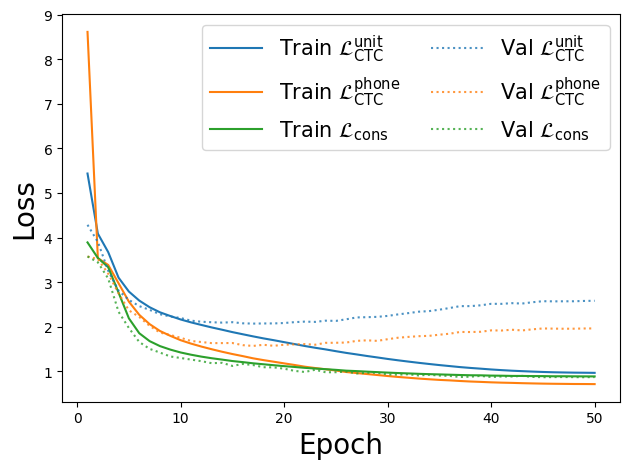

In [23]:
t = np.array(tLoss, dtype = float)
v = np.array(vLoss, dtype = float)

epochs = np.arange(1, t.shape[0] + 1)
names = [
    r'$\mathcal{L}_{\mathrm{CTC}}^{\mathrm{unit}}$',
    r'$\mathcal{L}_{\mathrm{CTC}}^{\mathrm{phone}}$',
    r'$\mathcal{L}_{\mathrm{cons}}$'
]

plt.figure()

trainLines, valLines = [], []

for i, name in enumerate(names):
    ln, = plt.plot(epochs, t[:, i])
    trainLines.append(ln)

for i, name in enumerate(names):
    ln, = plt.plot(
        epochs, v[:, i],
        linestyle = ":",
        alpha = 0.8,
        color = trainLines[i].get_color()
    )
    valLines.append(ln)

plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)

legendHandles = []
legendLabels = []

for i, name in enumerate(names):
    legendHandles.append(trainLines[i])
    legendLabels.append(f"Train {name}")

for i, name in enumerate(names):
    legendHandles.append(valLines[i])
    legendLabels.append(f"Val {name}")

plt.legend(
    legendHandles,
    legendLabels,
    ncol = 2,
    loc = "upper right",
    frameon = True,
    columnspacing = 1.5,
    handlelength = 2.5,
    fontsize = 15
)

plt.tight_layout()
plt.savefig("lossCurves.pdf", bbox_inches = "tight")
plt.show()

In [24]:
np.save("ckpts/largeVocabConv/valLoss.npy", valLOSS)

In [25]:
valLoss = np.load("ckpts/largeVocabConv/valLoss.npy")
print(np.min(valLoss))
print(np.argmin(valLoss) + 1)
epoch = np.argmin(valLoss)

1.9253895779450734
19


In [29]:
@torch.no_grad()
def testOperation(
    model,
    device,
    testLoader,
    ctcUnit,                         
    ctcPhone,                       
    lambdaPhone: float = 0.3,
):
    
    model.eval()
    outputsList = []

    lossUtotal = 0.0
    lossPtotal = 0.0
    lossTotal   = 0.0
    numBatches  = 0

    for (inputs, phoneTgts, unitTgts, inLens, phoneLens, unitLens) in testLoader:
        
        inputs     = inputs.to(device)        
        phoneTgts  = phoneTgts.to(device)    
        unitTgts   = unitTgts.to(device)     
        inLens     = inLens.to(device)       
        phoneLens  = phoneLens.to(device)     
        unitLens   = unitLens.to(device)      
        phoneTargets1d = _concatTargets(phoneTgts, phoneLens)
        unitTargets1d  = _concatTargets(unitTgts,  unitLens)

       
        out   = model(inputs)               
        logpU = out["unitLogprobs"]
        logpP = out["phoneLogprobs"]

        batchLossU = ctcUnit(logpU, unitTargets1d, inLens, unitLens)
        batchLossP = ctcPhone(logpP, phoneTargets1d, inLens, phoneLens)
        batchLoss   = (1.0 - lambdaPhone) * batchLossU + lambdaPhone * batchLossP

        batchDict = {
            "unitLogprobs":  logpU.transpose(0, 1).detach().cpu(),   
            "phoneLogprobs": logpP.transpose(0, 1).detach().cpu(),   
        }
        outputsList.append(batchDict)

        lossUtotal += float(batchLossU.item())
        lossPtotal += float(batchLossP.item())
        lossTotal   += float(batchLoss.item())
        numBatches  += 1

    metrics = {
        "lossUnit":  lossUtotal / max(1, numBatches),
        "lossPhone": lossPtotal / max(1, numBatches),
        "lossTotal": lossTotal   / max(1, numBatches),
    }
    return outputsList, metrics

In [27]:
modelWeight = torch.load("ckpts/largeVocabConv/" + str(epoch)  + '.pt', weights_only = True)
model.load_state_dict(modelWeight)

<All keys matched successfully>

In [30]:
outputs, metrics = testOperation(
    model, device, testLoader,
    ctcUnit, ctcPhone, lambdaPhone = 0.3
)

print(metrics)

{'lossUnit': 1.828394968211651, 'lossPhone': 1.3414910989254714, 'lossTotal': 1.6823238000273704}


In [31]:
"""
Simple beam-search algorithm.
"""

def ctcPrefixBeamSearch(
    logProbs,
    testLen = None,
    beamSize = 5,
    blank = 100,
    topk = None,
    allowDoubles = True,
):
    
    lp = np.asarray(logProbs)
    Ttotal, V = lp.shape
    T = Ttotal if testLen is None else int(min(testLen, Ttotal))

    beams = {(): (0.0, -np.inf)}

    def add(store, seq, addPb, addPnb):
        if seq in store:
            pb, pnb = store[seq]
            if addPb  != -np.inf: pb  = np.logaddexp(pb,  addPb)
            if addPnb != -np.inf: pnb = np.logaddexp(pnb, addPnb)
            store[seq] = (pb, pnb)
        else:
            store[seq] = (addPb, addPnb)

    for t in range(T):
        row = lp[t] 
        new = {}

        if topk is not None and topk < V:
            cand = np.argpartition(row, -topk)[-topk:]
            if blank not in cand:
                worstIdx = cand[np.argmin(row[cand])]
                cand[cand == worstIdx] = blank
        else:
            cand = range(V)

        for seq, (pb, pnb) in beams.items():
            add(new, seq, np.logaddexp(pb, pnb) + row[blank], -np.inf)

            last = seq[-1] if seq else None

            for c in cand:
                if c == blank:
                    continue
                pC = row[c]

                if c == last:
            
                    add(new, seq, -np.inf, pnb + pC)

                    if allowDoubles:
                        add(new, seq + (c,), -np.inf, pb + pC)
                else:
                    add(new, seq + (c,), -np.inf, np.logaddexp(pb, pnb) + pC)

        if len(new) > beamSize:
            items = sorted(new.items(),
                           key = lambda kv: np.logaddexp(*kv[1]),
                           reverse = True)[:beamSize]
            beams = dict(items)
        else:
            beams = new

    bestSeq = max(beams.items(), key = lambda kv: np.logaddexp(*kv[1]))[0]
    return bestSeq

def findClosestTranscription(decodedTranscript, phoneticTranscription):
    
    dist = Levenshtein.distance(decodedTranscript, phoneticTranscription)

    return dist

In [32]:
LEVS = []
decodedOut = []
for i in range(400):
    logp = outputs[i]["unitLogprobs"] 
    logpNp = logp.squeeze(0).numpy() 
    decodedSymbols = ctcPrefixBeamSearch(
    logProbs = logpNp,    
    beamSize = 1
) 
    decodedOut.append(decodedSymbols)

In [33]:
def findClosestTranscription(decodedTranscript, phoneticTranscription):
    
    dist = Levenshtein.distance(decodedTranscript, phoneticTranscription)

    return dist

In [34]:
levs = []
unitLENGTHS = []
for i in range(len(decodedOut)):
    unitLENGTHS.append(unitLabelLengths[9260 + i])
    levs.append(findClosestTranscription(decodedOut[i], unitizedLabels[9260 + i][:int(unitLabelLengths[9260 + i])]))
LEVS.append(np.mean(levs))

In [35]:
print(np.array(levs)/np.array(unitLENGTHS))

[0.41463415 0.47727273 0.31372549 0.34375    0.5        0.41025641
 0.575      0.43333333 0.34693878 0.55555556 0.32692308 0.53125
 0.5060241  0.53030303 0.25       0.62264151 0.53125    0.42592593
 0.61111111 0.41666667 0.58461538 0.43478261 0.5        0.4516129
 0.46153846 0.48484848 0.53125    0.44117647 0.40322581 0.59574468
 0.45652174 0.45       0.57407407 0.54166667 0.75862069 0.54098361
 0.63043478 0.53333333 0.35555556 0.48979592 0.50847458 0.46938776
 0.55263158 0.44827586 0.625      0.47887324 0.47826087 0.48484848
 0.5        0.52112676 0.51666667 0.48979592 0.50819672 0.61016949
 0.62711864 0.54716981 0.54545455 0.54166667 0.5        0.59459459
 0.45238095 0.47916667 0.52307692 0.52380952 0.55       0.45238095
 0.5        0.475      0.57377049 0.3877551  0.58928571 0.50909091
 0.50793651 0.40816327 0.31578947 0.5862069  0.48780488 0.40909091
 0.56097561 0.52941176 0.52631579 0.38095238 0.5        0.55102041
 0.64444444 0.62790698 0.43333333 0.675      0.52542373 0.33802817

In [37]:
print("Mean length of sentences: ", np.mean(unitLENGTHS))
print("Mean unit errors (insertion errors + deletion errors + substitution errors): ", np.mean(levs))
print("Percent unit error: ", np.sum(levs)/np.sum(unitLENGTHS))

Mean length of sentences:  53.065
Mean unit errors (insertion errors + deletion errors + substitution errors):  27.4
Percent unit error:  0.5163478752473382
